<a id =t> </a> <br>
***

# <center> <span style="color:blue;background:yellow"> [WNS Analytics Wizard 2019](https://datahack.analyticsvidhya.com/contest/wns-analytics-wizard-2019/) </span></center>

![](images/wns.png)
*** 

## Notebook Content
1. [Load Libraries](#0)
1. [Load Data](#1)
1. [Preprocessing](#a)
    1. [Process Logs and Items Data](#b)
    1. [Label Encoding](#2)
    1. [Date Columns Processing](#3)
1. [Feature Engineering](#4)
1. [CatBoost](#5)
    1. [Hyperparameters Optimization](#6)
    1. [Model Training and Prediction](#7)
    1. [Submission DataFrame](#8)

---

<a id=0> </a> <br>

## <span style="background:gray;color:red">1. </span><span style="background:yellow;color:blue">Load Libraries </span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import catboost as cgb
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')

<a id=1> </a> <br>

## <span style="background:gray;color:red">2. </span><span style="background:yellow;color:blue">Load Data </span>

In [2]:
# Load Data
train = pd.read_csv('Data/train/train.csv')
test = pd.read_csv('Data/test.csv')

logs = pd.read_csv('Data/train/view_log.csv')  # Log details of user ids

items = pd.read_csv('Data/train/item_data.csv') # Item details


### <center> <span style="color:blue;background:yellow"> Data Dictionary </span></center>
    
***

<span style="color:blue;background:gray;font-size:20px">train.csv :</span>

|Variable	|Definition|
|-----------|----------|
|impression_id	|AD impression id|
|impression_time	|Time of the impression at partner website|
|user_id	|user id|
|app_code	|Application Code for a partner website where the ad was shown|
|os_version	|Version of operating system|
|is_4G	|1-Using 4G, 0-No 4G|
|is_click	|(target) Whether user clicked the AD (1-click, 0-no click)|

---
<span style="color:blue;background:gray;font-size:20px">view_log.csv : </span>

|Variable	|Definition|
|-----------|----------|
|server_time	|Timestamp of the log|
|device_type	|Device type of the user|
|session_id	|Browser session id|
|user_id	|user id|
|item_id	|Item id|

---

<span style="color:blue;background:gray;font-size:20px">item_data.csv: </span>

|Variable	|Definition|
|-----------|----------|
|item_id	|Item id|
|item_price	|Price of the item|
|category_1	|Category depth 1|
|category_2	|Category depth 2|
|category_3	|Category depth 3|
|product_type	|anonymized item type|

----
<span style="color:blue;background:gray;font-size:20px"> test.csv: </span> test file contains the impressions for which the participants need to predict the click rate

---
<span style="color:blue;background:gray;font-size:20px">sample_submission.csv: </span> This file contains the format in which you have to submit your predictions.

---

In [3]:
print('Shape of train Data :', train.shape, '\n Shape of test data :', test.shape)

Shape of train Data : (237609, 7) 
 Shape of test data : (90675, 6)


In [4]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [5]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


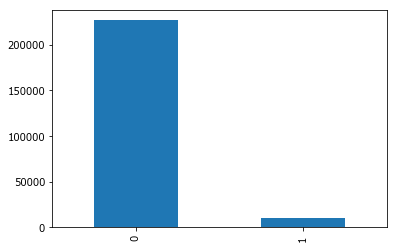

In [6]:
train['is_click'].value_counts().plot(kind='bar')

In [7]:
print('Click percentage :', train['is_click'].value_counts()[1]/train['is_click'].value_counts().sum()*100 , '%')

Click percentage : 4.571375663379754 %


In [8]:
items.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [9]:
items.shape

(132761, 6)

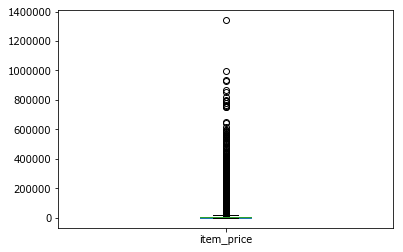

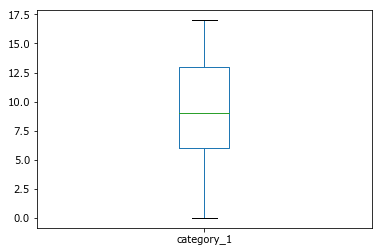

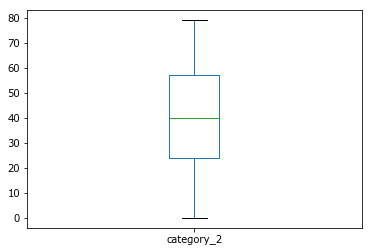

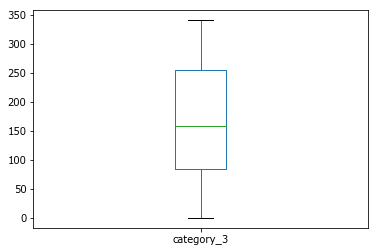

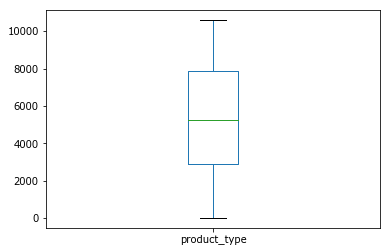

In [10]:
for col in items.columns[1:]:
    items[col].plot(kind='box')
    plt.show()


There are no outliers in items' variables except product price.

<a id=a> </a> <br>

## <span style="background:gray;color:red">3. </span><span style="background:yellow;color:blue">Preprocessing </span>

In [11]:
target = train['is_click'] # Get labels 
train.drop('is_click', axis=1, inplace=True) # Remove labels

<a id=b> </a> <br>

### <span style="background:gray;color:red">3.1 </span><span style="background:yellow;color:blue">Process Logs and Items Data </span>
* Merge Logs and Items DataFrame on `item_id`
* Merge new train and test DataFrames with Logs and Items merge DataFrame on `user_id'
* Create a Pivot table---> Make  pivot table with  `impression_id` as index , choose columns and define opeartions on them.
* Reset index of Pivot Table
* Rename columns of Pivot Table
* Merge Train and Test DataFrame with Pivot Table on `impression_id` 

In [12]:
df1 = pd.merge(logs,items, on='item_id', how="left")

In [13]:
%%time
def process_log_item(df):
    df_new = pd.merge(df,df1, on ="user_id", how="left")
    
    df_new = pd.pivot_table(df_new, index ='impression_id', 
               values=['user_id','item_id', 'item_price','category_1','category_2','category_3', 'product_type'], 
              aggfunc={'user_id':len,'item_id': lambda x:len(set(x)),
                       'item_price':[np.median,np.sum],
                       'category_1':[np.min, np.mean, np.max],
                       'category_2':[np.min, np.mean, np.max],
                       'category_3':[np.min, np.mean, np.max],
                       'product_type':[np.min, np.max]
                      })
    df_new = df_new.reset_index()
    
    df_new.columns = ['impression_id','cat1_max', 'cat1_min', 'cat1_mean',
                    'cat2_max', 'cat2_min', 'cat2_mean',
                    'cat3_max', 'cat3_min', 'cat3_mean',
                     'item_count',
                    'price_median', 'price_sum',
                    'product_type_max', 'product_type_min',
                    'impression_count']
    df = pd.merge(df,df_new, on ="impression_id", how="left" )
    return df

train = process_log_item(train)
test = process_log_item(test)

CPU times: user 22.2 s, sys: 3.88 s, total: 26.1 s
Wall time: 26.3 s


In [14]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,cat1_max,cat1_min,cat1_mean,cat2_max,...,cat2_mean,cat3_max,cat3_min,cat3_mean,item_count,price_median,price_sum,product_type_max,product_type_min,impression_count
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,11.0,11.0,11.000000,35.0,...,35.000000,20.0,20.0,20.000000,1,2350.0,2350.0,5622.0,5622.0,1
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,13.0,4.0,7.333333,76.0,...,67.000000,295.0,67.0,257.500000,7,3421.0,53434.0,9337.0,577.0,12
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,13.0,8.0,10.500000,67.0,...,44.000000,170.0,139.0,154.500000,2,1598.5,3197.0,2874.0,2325.0,2
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,17.0,0.0,9.277778,63.0,...,44.333333,313.0,20.0,159.444444,12,2307.0,179341.0,9959.0,1943.0,18
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,17.0,1.0,9.978261,76.0,...,32.652174,332.0,11.0,168.391304,34,3596.5,396471.0,10412.0,248.0,46


In [15]:
rm_col=['impression_id']

In [16]:
train1 = train.drop(rm_col, axis=1)

test1 = test.drop(rm_col, axis=1)

In [17]:
print('Shape of train Data :', train1.shape, '\n Shape of test data :', test1.shape)

Shape of train Data : (237609, 20) 
 Shape of test data : (90675, 20)


In [18]:
test1.head()

,impression_time,user_id,app_code,os_version,is_4G,cat1_max,cat1_min,cat1_mean,cat2_max,cat2_min,cat2_mean,cat3_max,cat3_min,cat3_mean,item_count,price_median,price_sum,product_type_max,product_type_min,impression_count
0,2018-12-13 07:44:00,44754,127,latest,1,1.0,1.0,1.000000,42.0,42.0,42.000000,220.0,220.0,220.000000,1,23424.0,23424.0,1617.0,1617.0,1
1,2018-12-13 07:45:00,29656,44,latest,0,17.0,0.0,9.638889,78.0,3.0,38.430556,336.0,15.0,138.000000,46,3840.0,774171.0,10059.0,507.0,72
2,2018-12-13 07:46:00,25234,296,latest,1,17.0,7.0,12.555556,46.0,0.0,20.444444,328.0,4.0,201.222222,7,2116.0,44771.0,5552.0,60.0,9
3,2018-12-13 07:47:00,22988,207,latest,1,17.0,0.0,7.162162,76.0,0.0,33.108108,338.0,84.0,219.432432,17,5248.0,555344.0,9776.0,344.0,37
4,2018-12-13 07:48:00,35431,242,latest,1,17.0,0.0,8.178571,78.0,3.0,36.678571,308.0,18.0,143.285714,26,3105.0,245792.0,10412.0,1349.0,28


<a id=2> </a> <br>

### <span style="background:gray;color:red">3.2 </span><span style="background:yellow;color:blue">LabelEncoding </span>

* Do label encoding for `os_version` column

In [19]:
encode_cols = ['os_version']
def labelencpode(df):
    enc = LabelEncoder()
    for col in encode_cols:
        enc.fit(df[col])
        df[col] = enc.transform(df[col])
    return df
train1 = labelencpode(train1)
test1 = labelencpode(test1)

In [20]:
train1.head()

,impression_time,user_id,app_code,os_version,is_4G,cat1_max,cat1_min,cat1_mean,cat2_max,cat2_min,cat2_mean,cat3_max,cat3_min,cat3_mean,item_count,price_median,price_sum,product_type_max,product_type_min,impression_count
0,2018-11-15 00:00:00,87862,422,2,0,11.0,11.0,11.000000,35.0,35.0,35.000000,20.0,20.0,20.000000,1,2350.0,2350.0,5622.0,5622.0,1
1,2018-11-15 00:01:00,63410,467,1,1,13.0,4.0,7.333333,76.0,43.0,67.000000,295.0,67.0,257.500000,7,3421.0,53434.0,9337.0,577.0,12
2,2018-11-15 00:02:00,71748,259,0,1,13.0,8.0,10.500000,67.0,21.0,44.000000,170.0,139.0,154.500000,2,1598.5,3197.0,2874.0,2325.0,2
3,2018-11-15 00:02:00,69209,244,1,1,17.0,0.0,9.277778,63.0,21.0,44.333333,313.0,20.0,159.444444,12,2307.0,179341.0,9959.0,1943.0,18
4,2018-11-15 00:02:00,62873,473,1,0,17.0,1.0,9.978261,76.0,0.0,32.652174,332.0,11.0,168.391304,34,3596.5,396471.0,10412.0,248.0,46


<a id=3> </a> <br>

### <span style="background:gray;color:red">3.3 </span><span style="background:yellow;color:blue">Date Columns Processing </span>

* Convert `impression_time` column to datetime format
* Get month, day of week, day of month and hour 

In [21]:
def date_col(df):
  df['impression_time'] = pd.to_datetime(df['impression_time'])
  df['dow'] = df['impression_time'].apply(lambda x: x.weekday())
  df["day"]  = df['impression_time'].apply(lambda x: x.day)
  df['hour'] = df['impression_time'].apply(lambda x: x.hour)
  df.drop('impression_time', axis=1, inplace=True)
  return df

train1 = date_col(train1)
test1 = date_col(test1)

<a id=4> </a> <br>

## <span style="background:gray;color:red">4. </span><span style="background:yellow;color:blue">Feature Engineering </span>

#### `I found high correlation between categories, item count, product type, and item price. To reduce correlation among them, I took ratios. It did not reduce correlation between target and independent variables.`  

In [22]:
rm_cols = ['cat1_max', 'cat1_min', 'cat1_mean','cat2_max', 'cat2_min', 'cat2_mean',
                    'cat3_max', 'cat3_min', 'cat3_mean','price_median', 'price_sum',
                    'product_type_max', 'product_type_min', 'item_count', 'impression_count']
def feat_eng(df):
    df['cat1'] = df['cat1_max']/(df['cat1_min'] + 1)
    df['cat12'] = df['cat2_max']/(df['cat2_min'] + 1)
    df['cat3'] = df['cat3_max']/ (df['cat3_min'] + 1)
    df['product_type'] = df['product_type_max'] /(df['product_type_min'] + 1)
    df['price'] = df['price_sum'] / df['price_median']
    df['f1'] = (df['cat1_mean'] + df['cat2_mean'] + df['cat3_mean'])/(df['item_count'] + df['impression_count'] )
    df['f2'] = df['item_count']/df['impression_count']
    df.drop(rm_cols, axis=1, inplace=True)
    return df
train1 = feat_eng(train1)
test1 = feat_eng(test1)

In [23]:
train1.head()

,user_id,app_code,os_version,is_4G,dow,day,hour,cat1,cat12,cat3,product_type,price,f1,f2
0,87862,422,2,0,3,15,0,0.916667,0.972222,0.952381,0.999822,1.000000,33.000000,1.000000
1,63410,467,1,1,3,15,0,2.600000,1.727273,4.338235,16.153979,15.619410,17.464912,0.583333
2,71748,259,0,1,3,15,0,1.444444,3.045455,1.214286,1.235598,2.000000,52.250000,1.000000
3,69209,244,1,1,3,15,0,17.000000,2.863636,14.904762,5.122942,77.737755,7.101852,0.666667
4,62873,473,1,0,3,15,0,8.500000,76.000000,27.666667,41.815261,110.238009,2.637772,0.739130


In [24]:
print('Shape of train Data :', train1.shape, '\n Shape of test data :', test1.shape)

Shape of train Data : (237609, 14) 
 Shape of test data : (90675, 14)


In [25]:
train1.head()

,user_id,app_code,os_version,is_4G,dow,day,hour,cat1,cat12,cat3,product_type,price,f1,f2
0,87862,422,2,0,3,15,0,0.916667,0.972222,0.952381,0.999822,1.000000,33.000000,1.000000
1,63410,467,1,1,3,15,0,2.600000,1.727273,4.338235,16.153979,15.619410,17.464912,0.583333
2,71748,259,0,1,3,15,0,1.444444,3.045455,1.214286,1.235598,2.000000,52.250000,1.000000
3,69209,244,1,1,3,15,0,17.000000,2.863636,14.904762,5.122942,77.737755,7.101852,0.666667
4,62873,473,1,0,3,15,0,8.500000,76.000000,27.666667,41.815261,110.238009,2.637772,0.739130


In [26]:
train1['is_click'] = target

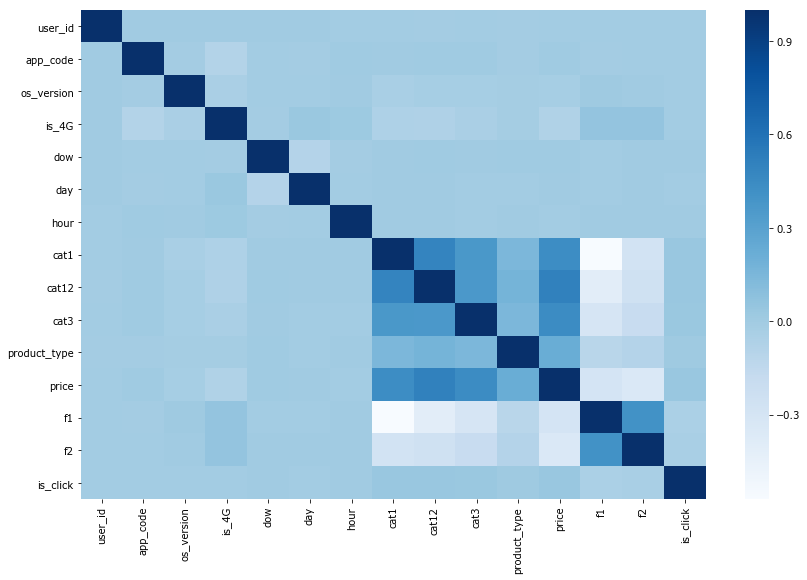

In [27]:
# Plot Correlation 
plt.subplots(figsize=(14,9))
data = train1.corr()
sns.heatmap(data, cmap ='Blues')

In [28]:
data

,user_id,app_code,os_version,is_4G,dow,day,hour,cat1,cat12,cat3,product_type,price,f1,f2,is_click
user_id,1.000000,0.000247,0.000619,0.000256,0.000825,0.001182,-0.006041,-0.002938,-0.011355,-0.003803,-0.009123,-0.003513,-0.001705,-0.002427,-0.001035
app_code,0.000247,1.000000,-0.008514,-0.081480,-0.005307,-0.008427,0.005997,0.003840,0.008385,0.007788,-0.007529,0.011439,-0.009962,-0.005235,-0.005449
os_version,0.000619,-0.008514,1.000000,-0.042513,-0.005353,-0.000696,0.001977,-0.031622,-0.021873,-0.021600,-0.016618,-0.024344,0.013099,0.000392,-0.004383
is_4G,0.000256,-0.081480,-0.042513,1.000000,-0.008040,0.031951,0.021178,-0.058801,-0.067454,-0.041896,-0.012725,-0.068685,0.054971,0.059102,-0.003464
dow,0.000825,-0.005307,-0.005353,-0.008040,1.000000,-0.090244,-0.008548,0.005085,0.008558,0.004601,0.005963,0.007911,-0.002673,0.001740,0.005079
day,0.001182,-0.008427,-0.000696,0.031951,-0.090244,1.000000,-0.000754,0.004308,-0.000254,-0.005244,-0.004282,-0.000159,-0.003164,0.003610,-0.005490
hour,-0.006041,0.005997,0.001977,0.021178,-0.008548,-0.000754,1.000000,0.002067,0.004232,-0.003652,0.001987,-0.004091,0.000788,0.000943,0.004081
cat1,-0.002938,0.003840,-0.031622,-0.058801,0.005085,0.004308,0.002067,1.000000,0.494979,0.369163,0.151976,0.438605,-0.571202,-0.271729,0.041205
cat12,-0.011355,0.008385,-0.021873,-0.067454,0.008558,-0.000254,0.004232,0.494979,1.000000,0.365111,0.171967,0.511105,-0.401917,-0.247874,0.038329
cat3,-0.003803,0.007788,-0.021600,-0.041896,0.004601,-0.005244,-0.003652,0.369163,0.365111,1.000000,0.152937,0.446636,-0.304930,-0.196400,0.031436


<span style='color:blue;background:yellow;font-size:20px'> `High correlation between independent variables doesn't affect boosting aglorithms as they take one variable at a time for split.Therefore, it is upto you, if you drop highly correlated variable or not.`  </span>

In [29]:
train1.drop('is_click', axis=1, inplace=True)

In [30]:
cat_cols = ['user_id','app_code', 'os_version', 'is_4G', 'day', 'dow', 'hour']

In [31]:
cat_feat =cat_cols

In [32]:
train1.head()

,user_id,app_code,os_version,is_4G,dow,day,hour,cat1,cat12,cat3,product_type,price,f1,f2
0,87862,422,2,0,3,15,0,0.916667,0.972222,0.952381,0.999822,1.000000,33.000000,1.000000
1,63410,467,1,1,3,15,0,2.600000,1.727273,4.338235,16.153979,15.619410,17.464912,0.583333
2,71748,259,0,1,3,15,0,1.444444,3.045455,1.214286,1.235598,2.000000,52.250000,1.000000
3,69209,244,1,1,3,15,0,17.000000,2.863636,14.904762,5.122942,77.737755,7.101852,0.666667
4,62873,473,1,0,3,15,0,8.500000,76.000000,27.666667,41.815261,110.238009,2.637772,0.739130


<a id=5> </a> <br>

## <span style="background:gray;color:red">5. </span><span style="background:yellow;color:blue">CatBoost </span>

<a id=6> </a> <br>

### <span style="background:gray;color:red">5.1 </span><span style="background:yellow;color:blue">Hyperparameters Optimization</span>

#### [Hyperparameters Optimization Tutorial](https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9) 

In [33]:
# Objective Function 

def hyp_cgb(depth, bagging_temperature, l2_leaf_reg, rsm):
    params = {"iterations": 120,
            "learning_rate": 0.05,
            "eval_metric": "AUC",
            "verbose": False,
             'use_best_model':True} # Default Parameters
    params[ "depth"] = int(round(depth)) 
    params["bagging_temperature"] = bagging_temperature
    params["l2_leaf_reg"] = l2_leaf_reg
    params["rsm"] = rsm
    
    cv_dataset = cgb.Pool(data=train1,
                  label=target, cat_features=cat_feat)

    scores = cgb.cv(cv_dataset,
              params,
              fold_count=5)
    return np.max(scores['test-AUC-mean'])  # Return Maximum AUC Value   

In [34]:
# Search space
pds = {'depth': (5, 12),
          'bagging_temperature': (0.1,1.5),
       'l2_leaf_reg':(0.1,5),
       'rsm':(0.1,1)
          }

In [35]:
# Surrogate model
optimizer = BayesianOptimization(hyp_cgb, pds, random_state=111)
                                  
# Optimize
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | baggin... |   depth   | l2_lea... |    rsm    |
-------------------------------------------------------------------------
|  1        |  0.7411   |  0.957    |  6.183    |  2.237    |  0.7923   |
|  2        |  0.7411   |  0.5135   |  6.044    |  0.2101   |  0.4782   |
|  3        |  0.7412   |  0.4342   |  7.364    |  4.954    |  0.314    |
|  4        |  0.7423   |  0.2137   |  9.687    |  3.144    |  0.3468   |
|  5        |  0.7408   |  0.7527   |  5.829    |  0.4624   |  0.9107   |
|  6        |  0.7412   |  1.318    |  11.93    |  4.995    |  0.5531   |
|  7        |  0.7419   |  0.5391   |  11.97    |  4.924    |  0.9131   |
|  8        |  0.7408   |  0.1897   |  11.96    |  4.953    |  0.1456   |
|  9        |  0.7407   |  0.4576   |  11.87    |  0.1432   |  0.1782   |
|  10       |  0.7379   |  1.497    |  5.029    |  5.0      |  0.1479   |
|  11       |  0.7419   |  0.2848   |  11.96    |  0.1155   |  0.9567   |
|  12       |  0.7417   |  0.3257   | 

optimizer.maximize(n_iter=5)

In [36]:
optimizer.max

{'target': 0.7423950646173031,
 'params': {'bagging_temperature': 0.16317943939048496,
  'depth': 11.926934535825037,
  'l2_leaf_reg': 0.16221405793270993,
  'rsm': 0.8827472294346276}}

In [37]:
p1 =optimizer.max['params']

In [38]:
cgb_param = {'learning_rate':0.05,
             'iterations': 3000,
             'rsm':p1['rsm'],
             'l2_leaf_reg': p1['l2_leaf_reg'],
             'depth':int(round(p1['depth'])),
             'bagging_temperature': p1['bagging_temperature'],
             'eval_metric':'AUC',
             'od_type': 'Iter',
             'od_wait': 150,
            }

In [39]:
cgb_param

{'learning_rate': 0.05,
 'iterations': 3000,
 'rsm': 0.8827472294346276,
 'l2_leaf_reg': 0.16221405793270993,
 'depth': 12,
 'bagging_temperature': 0.16317943939048496,
 'eval_metric': 'AUC',
 'od_type': 'Iter',
 'od_wait': 150}

<a id=7> </a> <br>

### <span style="background:gray;color:red">5.2 </span><span style="background:yellow;color:blue">Model Training and Prediction</span>

In [40]:
%%time
nfold = 10

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=127)

oof = np.zeros(len(train1))
predictions = np.zeros(len(test1))

i = 1
for train_index, valid_index in skf.split(target, target.values):
    print("fold {}".format(i))

    train_pool = cgb.Pool(train1.iloc[train_index], target[train_index], cat_features=cat_feat)
    validate_pool = cgb.Pool(train1.iloc[valid_index], target[valid_index], cat_features=cat_feat)
   
    model = cgb.CatBoostClassifier(**cgb_param, use_best_model=True)
    model.fit(train_pool, eval_set=validate_pool, verbose_eval=100)

    oof[valid_index] = model.predict_proba(cgb.Pool(train1.iloc[valid_index], cat_features=cat_feat))[:,1] 

    predictions += model.predict_proba(cgb.Pool(test1, cat_features=cat_feat))[:,1]/nfold
    i = i + 1

print("\n\nCV AUC-Score: {:<0.5f}".format(roc_auc_score(target, oof)))

fold 1
0:	test: 0.5379112	best: 0.5379112 (0)	total: 248ms	remaining: 12m 25s
100:	test: 0.7360605	best: 0.7370315 (92)	total: 36.4s	remaining: 17m 25s
200:	test: 0.7368302	best: 0.7386353 (161)	total: 1m 21s	remaining: 18m 53s
300:	test: 0.7293313	best: 0.7386353 (161)	total: 2m 16s	remaining: 20m 25s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7386353102
bestIteration = 161

Shrink model to first 162 iterations.
fold 2
0:	test: 0.5450716	best: 0.5450716 (0)	total: 235ms	remaining: 11m 43s
100:	test: 0.7441711	best: 0.7444651 (89)	total: 34.1s	remaining: 16m 19s
200:	test: 0.7429126	best: 0.7450445 (126)	total: 1m 23s	remaining: 19m 22s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.7450444615
bestIteration = 126

Shrink model to first 127 iterations.
fold 3
0:	test: 0.5559010	best: 0.5559010 (0)	total: 132ms	remaining: 6m 37s
100:	test: 0.7413693	best: 0.7414064 (94)	total: 33.2s	remaining: 15m 53s
200:	test: 0.7369050	best: 0.7414064 (9

In [41]:
predictions

array([0.0174993 , 0.03239551, 0.06310185, ..., 0.02737433, 0.0935424 ,
       0.13627831])

In [42]:
from sklearn import metrics

In [43]:
metrics.accuracy_score(target, np.round(oof))

0.9542357402286951

In [44]:
print(metrics.confusion_matrix(target, np.round(oof)))

[[226725     22]
 [ 10852     10]]


In [45]:
print(metrics.classification_report(target, np.round(oof)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    226747
           1       0.31      0.00      0.00     10862

   micro avg       0.95      0.95      0.95    237609
   macro avg       0.63      0.50      0.49    237609
weighted avg       0.92      0.95      0.93    237609



<a id=8> </a> <br>

### <span style="background:gray;color:red">5.3</span><span style="background:yellow;color:blue">Submission DataFrame</span>

In [46]:
sub = pd.read_csv('sample_submission.csv')

In [47]:
sub['is_click'] = predictions

In [48]:
sub.head()

,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0.017499
1,caac14a5bf2ba283db7708bb34855760,0.032396
2,13f10ba306a19ce7bec2f3cae507b698,0.063102
3,39c4b4dc0e9701b55a0a4f072008fb3f,0.011893
4,bf5a572cca75f5fc67f4b14e58b11d70,0.107453


In [49]:
sub.to_csv('Data/sub_cgb.csv', index =False)



## <center><span style="background:gray;color:red">End of the NoteBook</span></center>
***

### <center><span style="background:yellow;color:blue">[GO TO TOP](#t)</span></center> 